<h3> Performing the binary optimization for the optimal number of generators

In [1]:
from Genetic_Algorithm import Binary_Genetic_Algorithm
import numpy as np
import pypsa
import matplotlib.pyplot as plt
from numpy.random import randint, rand
import pandas as pd

import logging
logging.disable(logging.INFO)

plt.rcParams.update({
        "font.weight": "bold",  # bold fonts
        "font.size":10,
        "lines.linewidth": 2,   # thick lines
        "grid.color": "0.5",    # gray gridlines
        "grid.linewidth": 0.5,  # thin gridlines
        "savefig.dpi": 300,     # higher resolution output.
        "axes.labelsize" : 15
    })

In [2]:
#working floder = "dry" or "wet"

working_folder = "dry"

csv_folder_name = "Data_Folder/Eastern_grid_data/" + working_folder + "_season_data"
result_folder = "Data_Folder/Eastern_grid_data/"+ working_folder + "_results/"

fig_size = (12,6)

network = pypsa.Network()
network.import_from_csv_folder(csv_folder_name)

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 3], imported network file PyPSA version None.



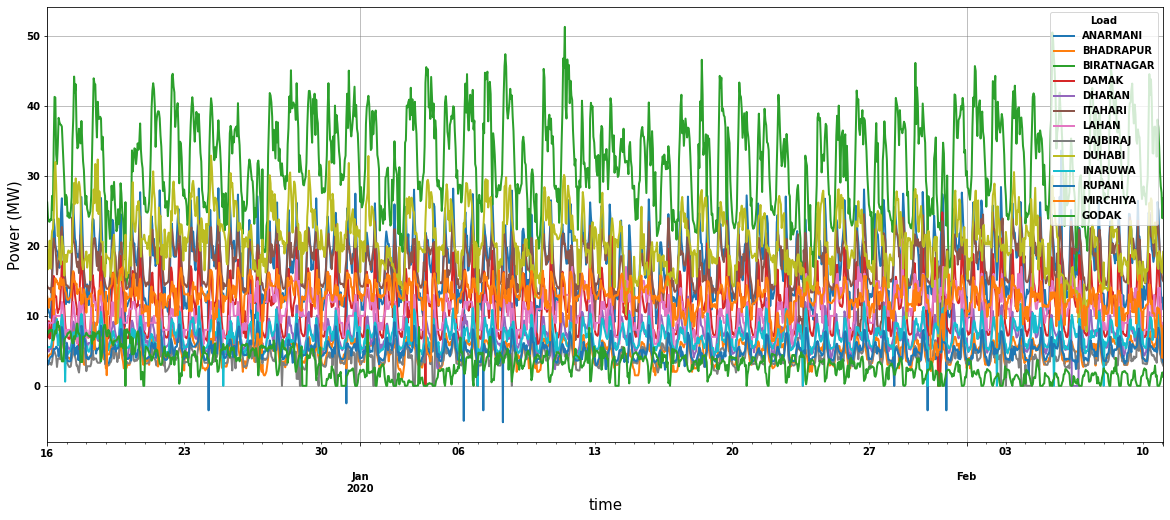

In [3]:
fig,ax = plt.subplots(figsize = (20,8))
network.loads_t.p_set.plot(ax= ax)
ax.set_xlabel("time")
ax.set_ylabel("Power (MW)")
ax.grid()
plt.savefig("Images/dry_season_loading.jpg",dpi = 300,bbox_inches = 'tight')

In [4]:
#perform load flow for differernt generation and load condition
def PowerFlow(Network_data):
    for i in range(len(Network_data.snapshots)):
        snapshot = Network_data.snapshots[i]
        Network_data.generators.p_set = Network_data.generators.p_nom*Network_data.generators_t.p_max_pu.iloc[i] #updating the geneation with max geneartiaon
        Network_data.pf(snapshot)
    return Network_data

In [5]:
solar_inst_cost = 580000
hydro_inst_cost = 2135000#irena
road_per_km_cost = 85088 #article
substation_cost_per_mva = 29364#nea
line_cost_per_km_per_mw = 2100 #article
#40 per kW per year maintainance cost hydro irena 2021

In [6]:
#add capital cost of generators
#add cost to slack export positive import negative
for i in range(len(network.generators)):
    d_sub = network.generators.sub_dist[i]
    d_road = network.generators.road_dist[i]
    typ =network.generators.carrier[i]
    if typ == "Solar":
        network.generators.capital_cost[i] = d_sub * line_cost_per_km_per_mw*network.generators.p_nom[i] + d_road*road_per_km_cost + network.generators.p_nom[i]*solar_inst_cost + substation_cost_per_mva*network.generators.p_nom[i]/0.8
    if typ == "Hydro":
        network.generators.capital_cost[i] = d_sub * line_cost_per_km_per_mw*network.generators.p_nom[i] + d_road*road_per_km_cost + network.generators.p_nom[i]*hydro_inst_cost + substation_cost_per_mva*network.generators.p_nom[i]/0.8

/tmp/ipykernel_3656/2723456601.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3656/2723456601.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [7]:
#updating network with optimal number of generators
def update_network(network,x_opt):
    network_new = network.copy()
    gen_off = np.where(x_opt == 0)
    network_new.generators=network_new.generators.drop(network_new.generators.index[gen_off], axis = 0)
    network_new.generators_t.p_max_pu = network_new.generators_t.p_max_pu.drop(network_new.generators_t.p_max_pu.columns[gen_off],axis= 1)
    return network_new

In [8]:
line_s_nom = pd.read_csv('line_s_nom.csv')
network.lines.s_nom = line_s_nom.s_nom_max.values

In [9]:
snapshots = network.snapshots
start_date = snapshots[0]
end_date = snapshots[24*57]
network.snapshots = network.snapshots[(network.snapshots >= start_date) & (network.snapshots <= end_date)]

In [10]:
def Objective(x):
    u_network = update_network(network,x)
    flow_nom = u_network.lines.s_nom.values
    is_under_limit = 1
    for i in range(len(network.snapshots)):
        snapshot = u_network.snapshots[i]
        u_network.generators.p_set = u_network.generators.p_nom*u_network.generators_t.p_max_pu.loc[snapshot] #updating the geneation with max geneartiaon
        u_network.pf(snapshot)
        bus_voltage = u_network.buses_t.v_mag_pu.loc[snapshot].values
        line_flow = u_network.lines_t.p0.loc[snapshot].values
        slack_power = u_network.generators_t.p.loc[snapshot].values[0]
        if (np.abs(line_flow)>flow_nom).any() or (bus_voltage>1.1).any() or (bus_voltage<0.9).any() or slack_power>0:
            is_under_limit = 0
            break

    if is_under_limit == 0:
        return np.inf
    if is_under_limit == 1:
        return u_network.generators.capital_cost.sum()

In [11]:
n_iter = 40
n_bits = len(network.generators)
n_pop = 10
r_cross = 0.8
r_mut = 1/float(n_bits)

problem = Binary_Genetic_Algorithm(objective=Objective,n_bits=n_bits,n_iter=n_iter,n_pop= n_pop,r_cross=r_cross,r_mut=r_mut)


In [12]:
best_bits, best_eval = problem.optimize()

Generation  0
Best Bits [0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 1 0 0 1 0 1 1
 1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1]
Best Cost 1739390237.0319781
Generation  1
Best Bits [0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0
 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0]
Best Cost 1289518374.50983
Generation  2
Best Bits [0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0
 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0]
Best Cost 1176954408.5076735
Generation  3
Best Bits [0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0]
Best Cost 1123753809.0901492
Generation  4
Best Bits [0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0]
Best Cost 1123753809.0901492
Generation  5
Best Bits [0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1
 0 1 0 0 0 0 1 0 1 1 0 

In [13]:
best_bits

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [11]:
best_bits= np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [12]:
optimal_network = update_network(network,best_bits)

In [13]:
for i in range(len(optimal_network.generators)):
    if optimal_network.generators.bus[i] == "Kataiya_400":
        optimal_network.generators.control[i] = "Slack"

In [14]:
optimal_network = PowerFlow(optimal_network)

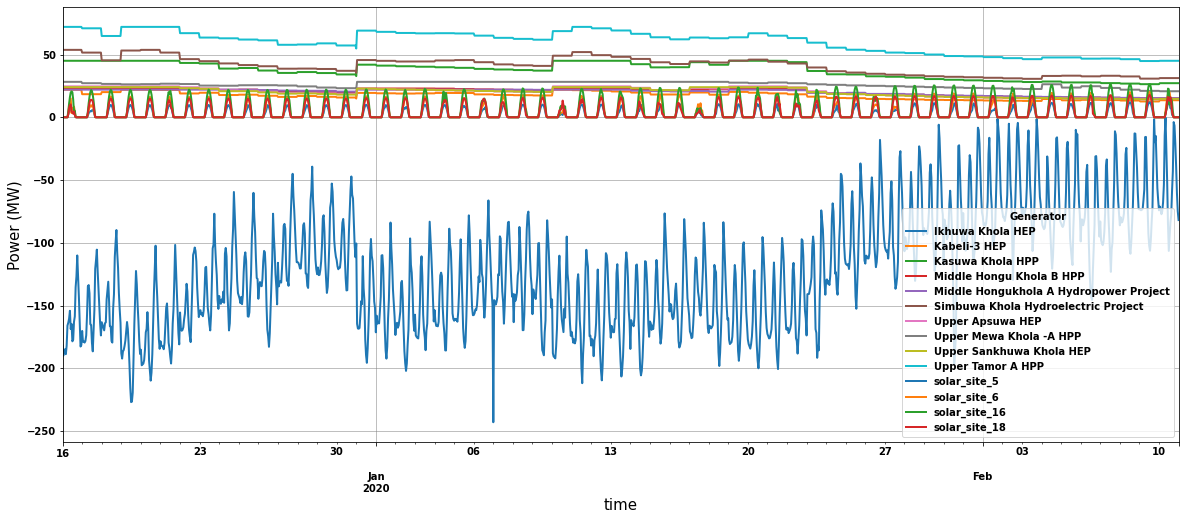

In [16]:
fig,ax = plt.subplots(figsize = (20,8))
optimal_network.generators_t.p.plot(ax= ax)
ax.set_xlabel("time")
ax.set_ylabel("Power (MW)")
ax.grid()
plt.savefig("Images/dry_season_share.jpg",dpi = 300,bbox_inches = 'tight')

In [17]:
optimal_network.generators_t.p['total_generation'] = optimal_network.generators_t.p.sum(axis = 1)
optimal_network.loads_t.p['total_load'] = optimal_network.loads_t.p.sum(axis = 1)
loss = optimal_network.generators_t.p.total_generation - optimal_network.loads_t.p.total_load

<AxesSubplot:xlabel='snapshot'>

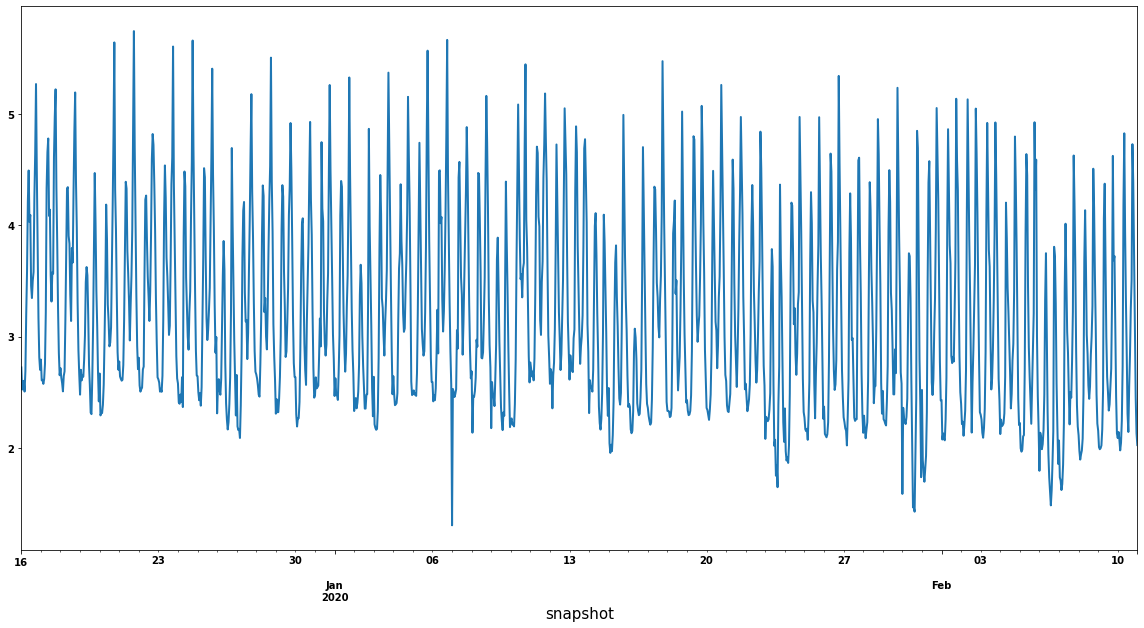

In [18]:
fig,ax = plt.subplots(figsize = (20,10))
loss.plot(ax=ax)

In [22]:
#power pooling